<div style="text-align: right;">© 2025 Moses Boudourides. All Rights Reserved.</div>

## *instats* Workshop, March 9-12, 2025 
### https://instats.org/seminar/hypernetworks-in-theory-and-practice

# KEY METHODS OF HYPERGRAPH ANALYSIS
## Moses Boudourides

# II. FROM GRAPHS TO HYPERGRAPHS

<span style="color:green">
    
### [1. Traversals](#1)

### [2. Distance, Eccentricity, Diameter, and Connected Components](#2)

### [3. s-Distance, s-Eccentricity, s-Diameter, and s-Connected Components](#3)
    
### [4. Simplicial Representation of Hypergraphs](#4)

### [5. Bipartite Representation of Hypergraphs](#5)
            
</span>

In [1]:
import pandas as pd
import numpy as np
import random
import string
import itertools
from collections import Counter
lowercase_letters = list(string.ascii_lowercase)
uppercase_letters = list(string.ascii_uppercase)
import hypernetx as hnx
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
all_colors = list(mcolors.CSS4_COLORS.keys())
import pyvis
from pyvis.network import Network
import xgi
from IPython.display import IFrame
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="hypernetx")

In [2]:
def hypergraph_random_creator(vertices, hyperedge_names, m, minv, maxv, mw):
    """
    Creates a random hypergraph with custom vertex and hyperedge names.

    Parameters:
    - vertices (list of int or str): List of vertex names.
    - hyperedge_names (list of str): List of hyperedge names.
    - m (int): Number of hyperedges to create (must be <= length of hyperedge_names).
    - minv (int): Minimum number of nodes in a hyperedge.
    - maxv (int): Maximum number of nodes in a hyperedge (must be > minv).
    - mw (int): Determines the vertex format.
        - If mw == 0 or mw == 1, the function returns the hypergraph dictionary.
        - If mw > 1, vertices are represented as dictionaries with keys as vertex names and values as random integers between 1 and mw.

    Returns:
    - hg_d (dict): A dictionary representing the hypergraph, with sorted node sets.
    """
    # Check if m is valid
    if m > len(hyperedge_names):
        raise ValueError("m cannot be greater than the number of hyperedge names provided.")
    
    hg_d = {}
    for k in range(m):
        r = random.randint(minv, maxv)
        nodes = random.sample(vertices, r)
        sorted_nodes = sorted(nodes)

        # If mw > 1, modify vertices to be dictionaries
        if mw > 1:
            sorted_nodes = {node: random.randint(1, mw) for node in sorted_nodes}
        
        hg_d[hyperedge_names[k]] = sorted_nodes
        
    return hg_d

def hgp_hnx(d):
    """
    Prints a hypergraph dictionary and plots the Euler diagram of the hypergraph using HyperNetX.
    """
    H = hnx.Hypergraph(d)
    hnx.drawing.draw(H)
    plt.show()
    
def is_connected(hypergraph):
    nodes = set([node for edge in hypergraph.values() for node in edge])
    visited = set()
    def dfs(node):
        visited.add(node)
        for edge in hypergraph.values():
            if node in edge:
                for neighbor in edge:
                    if neighbor not in visited:
                        dfs(neighbor)
    dfs(next(iter(nodes)))
    return visited == nodes

def is_linear(hypergraph):
    for e1, e2 in itertools.combinations(hypergraph, 2):
        if len(set(hypergraph[e1]) & set(hypergraph[e2])) > 1:
            return False  
    return True  


def generate_random_walk(hypergraph, min_length):
    nodes = list(set([node for edge in hypergraph.values() for node in edge]))
    edges = list(hypergraph.keys())
    S = []
    current_node = random.choice(nodes)
    current_edge = random.choice([edge for edge, nodes_in_edge in hypergraph.items() if current_node in nodes_in_edge])
    S.append((current_node, current_edge))
    while len(S) < min_length:
        last_node, last_edge = S[-1]
        possible_nodes = [node for node in hypergraph[last_edge] if node != last_node]
        if not possible_nodes:
            possible_edges = [edge for edge in edges if last_node in hypergraph[edge] and edge != last_edge]
            if not possible_edges:
                current_node = random.choice(nodes)
                current_edge = random.choice([edge for edge, nodes_in_edge in hypergraph.items() if current_node in nodes_in_edge])
                S = [(current_node, current_edge)]
                continue
            next_edge = random.choice(possible_edges)
            next_node = last_node  
        else:
            next_node = random.choice(possible_nodes)
            if len(S) >= 2 and S[-2][1] == last_edge:
                possible_next_edges = [edge for edge in edges if edge != last_edge and next_node in hypergraph[edge]]
            else:
                possible_next_edges = [edge for edge in edges if next_node in hypergraph[edge]]
            
            if not possible_next_edges:
                S.pop()  
                continue         
            next_edge = random.choice(possible_next_edges)        
        S.append((next_node, next_edge))    
    return S


def is_proper_walk(hypergraph,S):
    adj = all(s[0] in hypergraph[s[1]] for s in S)
    vertices = [v for v, _ in S]
    hyperedges = [e for _, e in S]
    return len(vertices) > len(set(vertices)) and len(hyperedges) > len(set(hyperedges))

def is_proper_trail(hypergraph,S):
    adj = all(s[0] in hypergraph[s[1]] for s in S)
    vertices = [v for v, _ in S]
    hyperedges = [e for _, e in S]
    return len(vertices) > len(set(vertices)) and len(hyperedges) == len(set(hyperedges))

def is_path(hypergraph,S):
    adj = all(s[0] in hypergraph[s[1]] for s in S)
    vertices = [v for v, _ in S]
    hyperedges = [e for _, e in S]
    return len(vertices) == len(set(vertices)) and len(hyperedges) == len(set(hyperedges))

def find_cycle(hypergraph, length):
    def dfs(path, visited_edges):
        if len(path) == length + 1 and path[0][0] == path[-1][0]:  
            return path      
        last_vertex, last_edge = path[-1]        
        for edge in hypergraph:
            if edge in visited_edges:
                continue        
            if last_vertex in hypergraph[edge]:  
                for next_vertex in hypergraph[edge]:
                    if next_vertex != last_vertex:  
                        new_path = path + [(next_vertex, edge)]
                        new_visited = visited_edges | {edge}
                        result = dfs(new_path, new_visited)
                        if result:
                            return result  
        return None
    for edge, vertices in hypergraph.items():
        for vertex in vertices:
            result = dfs([(vertex, edge)], {edge})
            if result:
                return result  
            
def eccentricities(hypergraph):
    H=hnx.Hypergraph(hypergraph)
    eccentricity = {}
    for i in H.nodes:
        max_distance = 0
        for j in H.nodes:
            if i != j:
                d = H.distance(i, j, s=1)  
                if d is not None:  
                    max_distance = max(max_distance, d)
        eccentricity[int(i)] = max_distance  
    return eccentricity

<a id='1'></a>
## <span style="color:green">1. Traversals</span>

{'e1': [4, 8, 13, 18], 'e2': [2, 8, 16, 17], 'e3': [2, 3, 7, 8, 10, 11], 'e4': [6, 9, 10, 11, 17], 'e5': [4, 13, 19], 'e6': [0, 6, 12, 18], 'e7': [0, 3, 6, 8, 14, 16], 'e8': [3, 5, 12, 19]}
diameter= 3


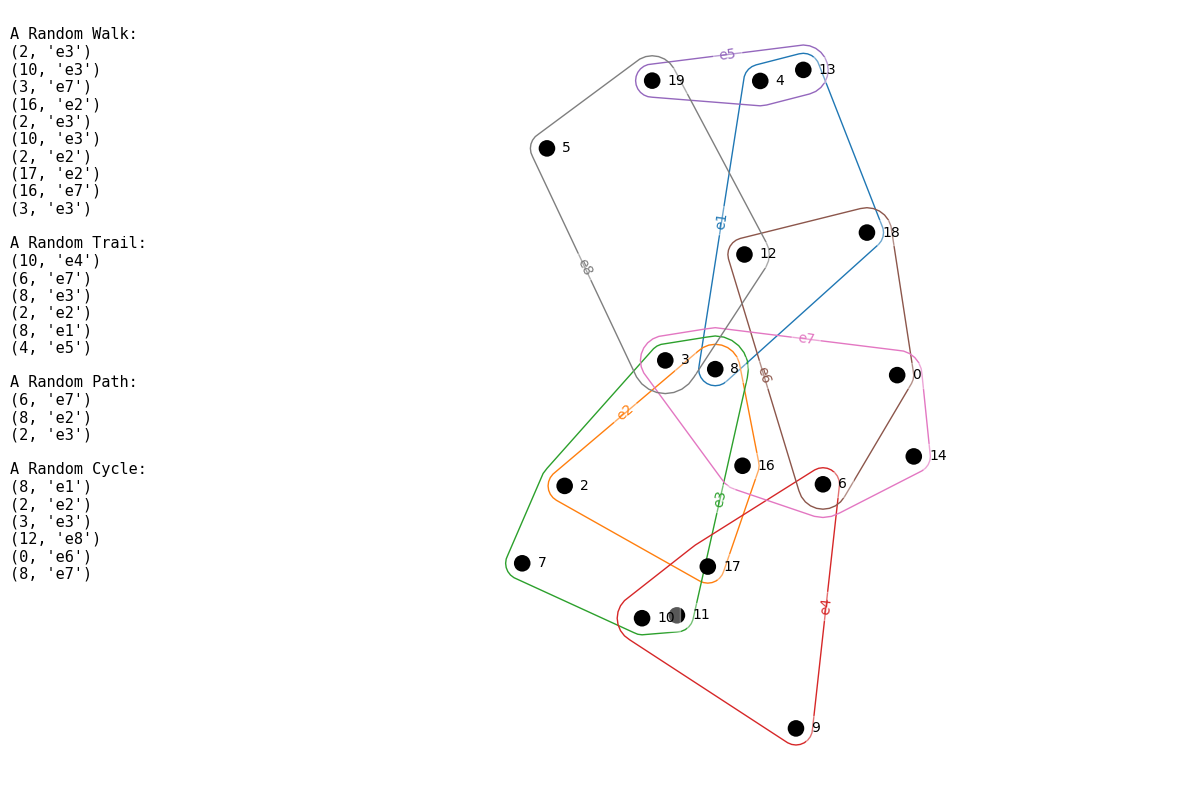

In [3]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): #and H.diameter(s=1)>5:
        cycle = find_cycle(hg_d, length=5)
        if cycle:
            break

print(hg_d)
H=hnx.Hypergraph(hg_d)
print("diameter=",H.diameter(s=1))

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []
text_output.append("\nA Random Walk:")
walk = generate_random_walk(hypergraph=hg_d, min_length=10)
for x in walk:
    text_output.append(str(x))

text_output.append("\nA Random Trail:")
while True:
    walk = generate_random_walk(hypergraph=hg_d, min_length=6)
    if is_proper_trail(hypergraph=hg_d,S=walk):
        break
for x in walk:
    text_output.append(str(x))

text_output.append("\nA Random Path:")
while True:
    walk = generate_random_walk(hypergraph=hg_d, min_length=hnx.Hypergraph(hg_d).diameter(s=1))
    if is_path(hypergraph=hg_d,S=walk):
        break
for x in walk:
    text_output.append(str(x))

text_output.append("\nA Random Cycle:")
for x in cycle:
    text_output.append(str(x))

text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

{'e1': [2, 9, 12, 13, 15, 17], 'e2': [12], 'e3': [4, 19], 'e4': [8, 15, 19], 'e5': [1, 3, 8, 13, 18, 19], 'e6': [2, 4, 7, 12, 15, 16], 'e7': [1], 'e8': [8, 15, 16]}
diameter= 3


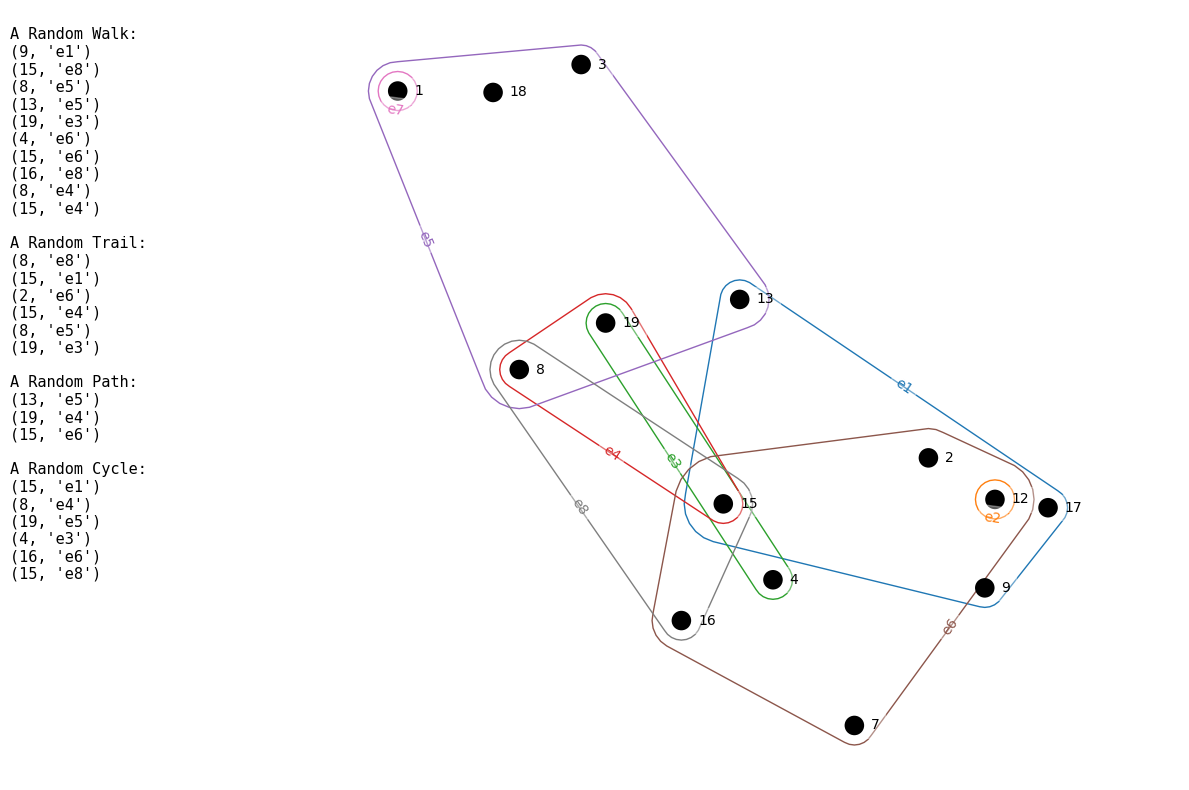

In [4]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): #and H.diameter(s=1)>5:
        cycle = find_cycle(hg_d, length=5)
        if cycle:
            break

print(hg_d)
H=hnx.Hypergraph(hg_d)
print("diameter=",H.diameter(s=1))

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []
text_output.append("\nA Random Walk:")
walk = generate_random_walk(hypergraph=hg_d, min_length=10)
for x in walk:
    text_output.append(str(x))

text_output.append("\nA Random Trail:")
while True:
    walk = generate_random_walk(hypergraph=hg_d, min_length=6)
    if is_proper_trail(hypergraph=hg_d,S=walk):
        break
for x in walk:
    text_output.append(str(x))

text_output.append("\nA Random Path:")
while True:
    walk = generate_random_walk(hypergraph=hg_d, min_length=hnx.Hypergraph(hg_d).diameter(s=1))
    if is_path(hypergraph=hg_d,S=walk):
        break
for x in walk:
    text_output.append(str(x))

text_output.append("\nA Random Cycle:")
for x in cycle:
    text_output.append(str(x))

text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='2'></a>
## <span style="color:green">2. Distance, Eccentricity, Diameter, and Connected Components</span>

{'e1': [0, 1, 5, 6, 7], 'e2': [1, 4], 'e3': [2, 9], 'e4': [2, 7], 'e5': [2, 5, 7]}


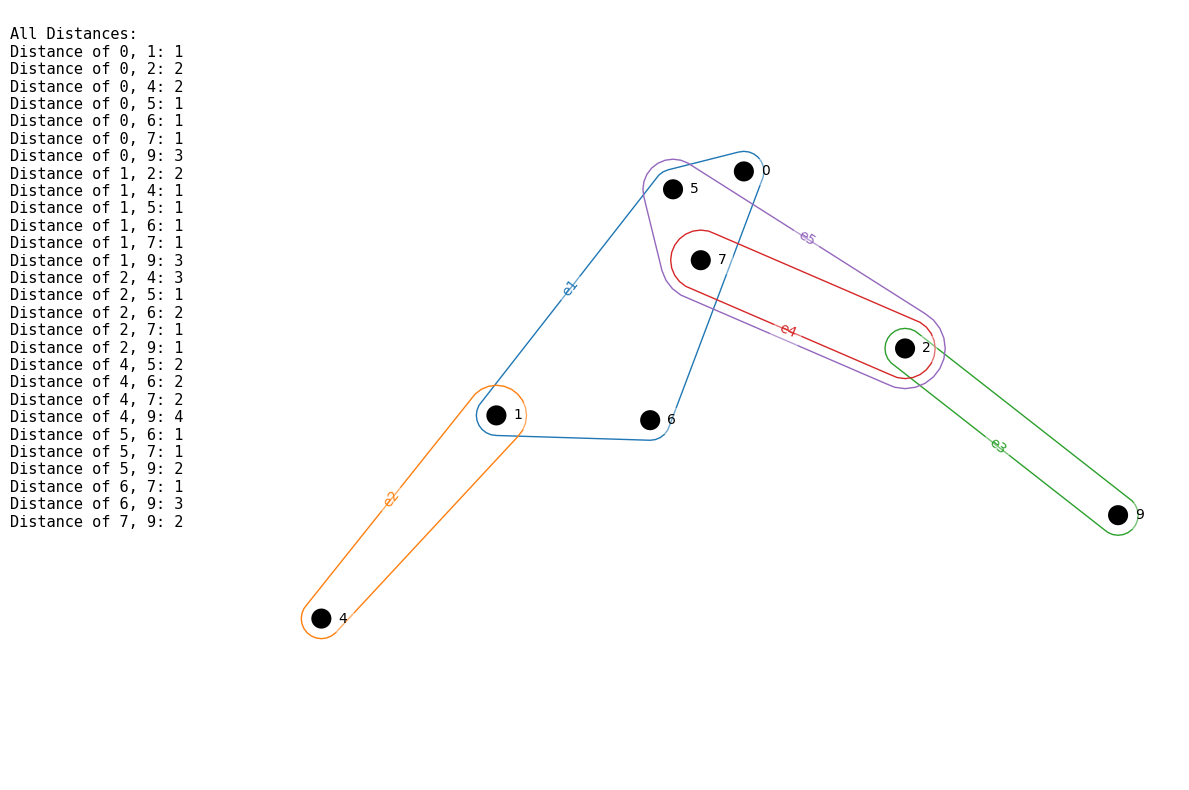

In [5]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(10)), hyperedge_names=[f"e{i+1}" for i in range(5)], m=5, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d) and H.diameter(s=1)>3 and not is_linear(hg_d): 
        break

print(hg_d)
H=hnx.Hypergraph(hg_d)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []
text_output.append("\nAll Distances:")
nodes = sorted(set([node for edge in hg_d.values() for node in edge]))
for i in nodes:
    for j in nodes:
        if i != j and i < j:
            distance = H.distance(i, j, s=1)
            text_output.append(f"Distance of {i}, {j}: {distance}")

text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

{'e1': [7], 'e2': [2, 7], 'e3': [0, 2], 'e4': [1, 3, 4, 5, 7, 9], 'e5': [1, 3, 4, 6]}
diameter= 4


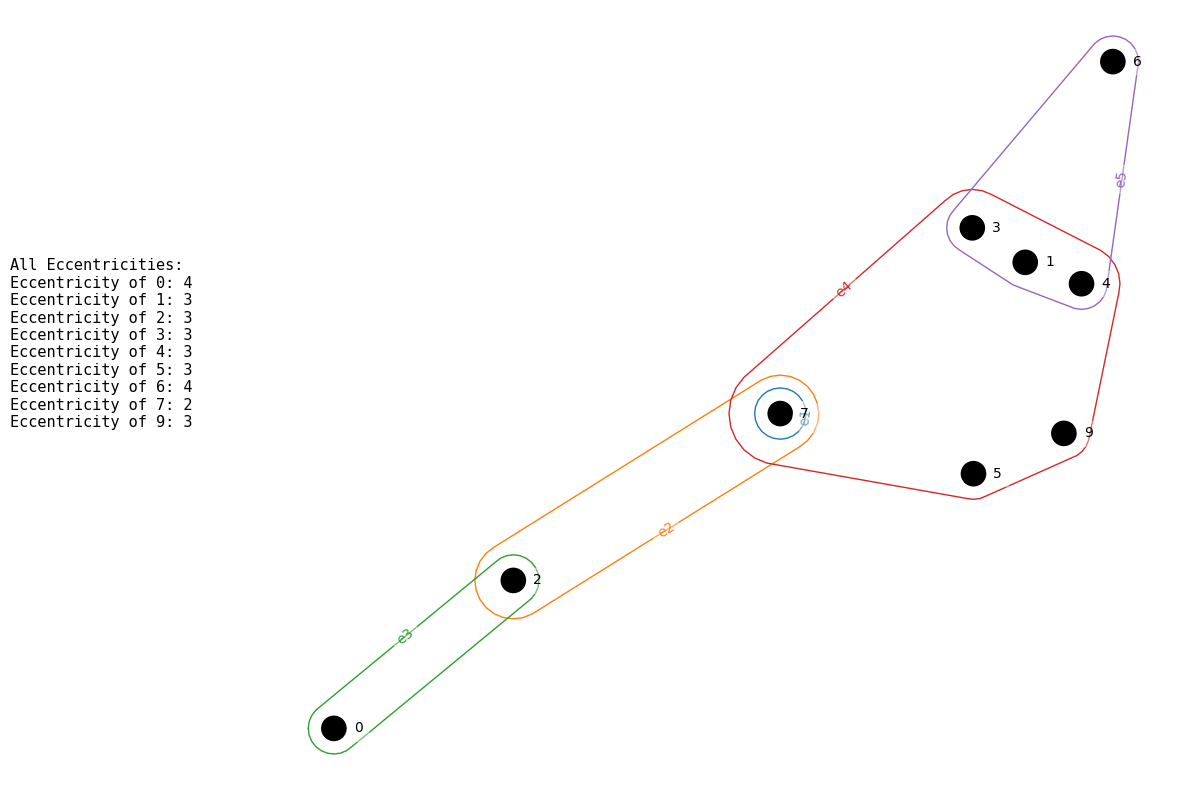

In [6]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(10)), hyperedge_names=[f"e{i+1}" for i in range(5)], m=5, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d) and H.diameter(s=1)>3 and not is_linear(hg_d): 
        break

print(hg_d)
H=hnx.Hypergraph(hg_d)
print("diameter=",H.diameter(s=1))

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []
text_output.append("\nAll Eccentricities:")
eccentricity = eccentricities(hg_d)
for k,v in sorted(eccentricity.items()):
    text_output.append(f"Eccentricity of {k}: {v}")

text_display = "\n".join(text_output)
ax1.text(0, 0.7, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

{'e1': [0, 14], 'e2': [3], 'e3': [17], 'e4': [3, 18], 'e5': [9, 16], 'e6': [15], 'e7': [16], 'e8': [14], 'e9': [6, 7, 15], 'e10': [10]}


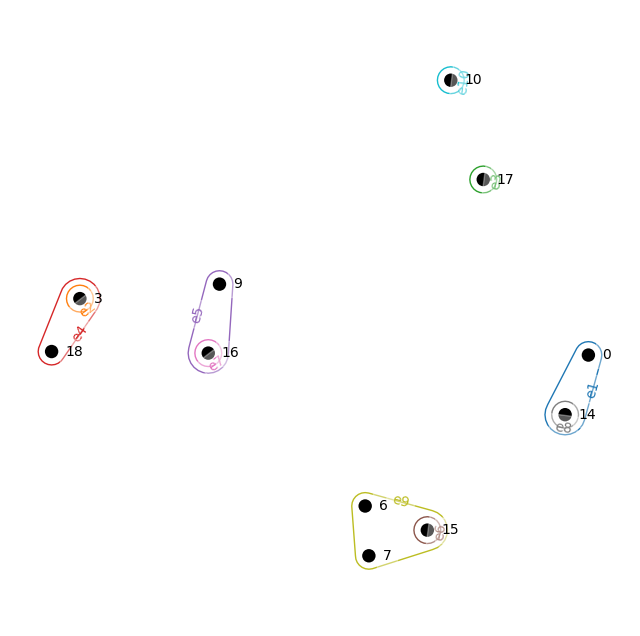

In [7]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(10)], m=10, minv=1, maxv=4, mw=0)
    H=hnx.Hypergraph(hg_d)
    if not is_connected(hg_d):
        if len(list(H.s_component_subgraphs(s=1))) > 3:
            if all(len(S)>1 for S in list(H.s_component_subgraphs(s=1))):
                break
print(hg_d)
H=hnx.Hypergraph(hg_d)

hnx.draw(H)
plt.show()

<a id='3'></a>
## <span style="color:green">3. s-Distance, s-Eccentricity, s-Diameter, and s-Connected Components</span>

{'e1': [0, 1, 4, 8, 9], 'e2': [5], 'e3': [0, 1, 5, 6, 8, 9], 'e4': [0, 1, 2, 4, 6, 8], 'e5': [0, 2, 5, 8, 9]}


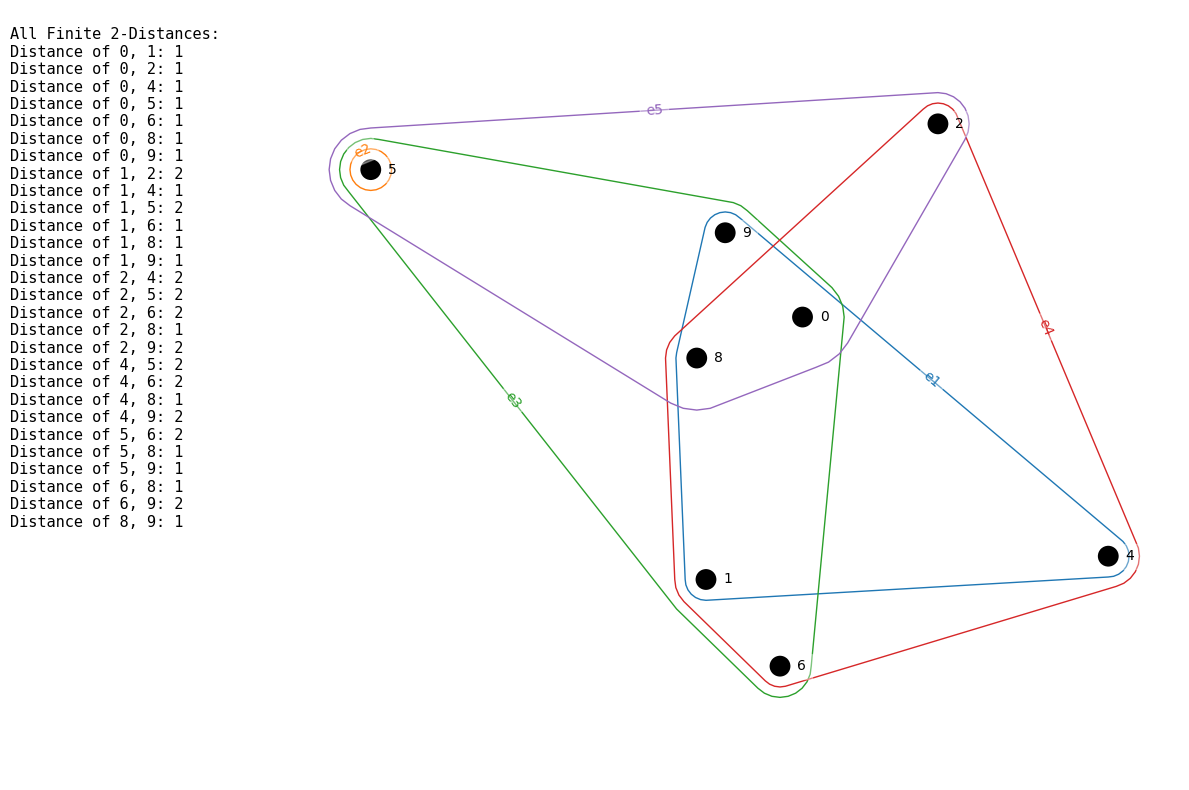

In [8]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(10)), hyperedge_names=[f"e{i+1}" for i in range(5)], m=5, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        mat, rindex = H.adjacency_matrix(s=3,index=True)
        mat=mat.toarray()
        if np.count_nonzero(mat) > 6:
            break

print(hg_d)
H=hnx.Hypergraph(hg_d)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []
text_output.append("\nAll Finite 2-Distances:")
nodes = sorted(set([node for edge in hg_d.values() for node in edge]))
for i in nodes:
    for j in nodes:
        if i != j and i < j:
            distance = H.distance(i, j, s=2)
            if type(distance) == int:
                text_output.append(f"Distance of {i}, {j}: {distance}")

text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

{'e1': [0, 5, 7], 'e2': [0, 3, 4, 5, 6, 9], 'e3': [1, 2, 4, 5, 6, 8], 'e4': [2, 3, 5, 6, 7, 8], 'e5': [0, 1, 3, 4, 7, 9]}
2-diameter = 3


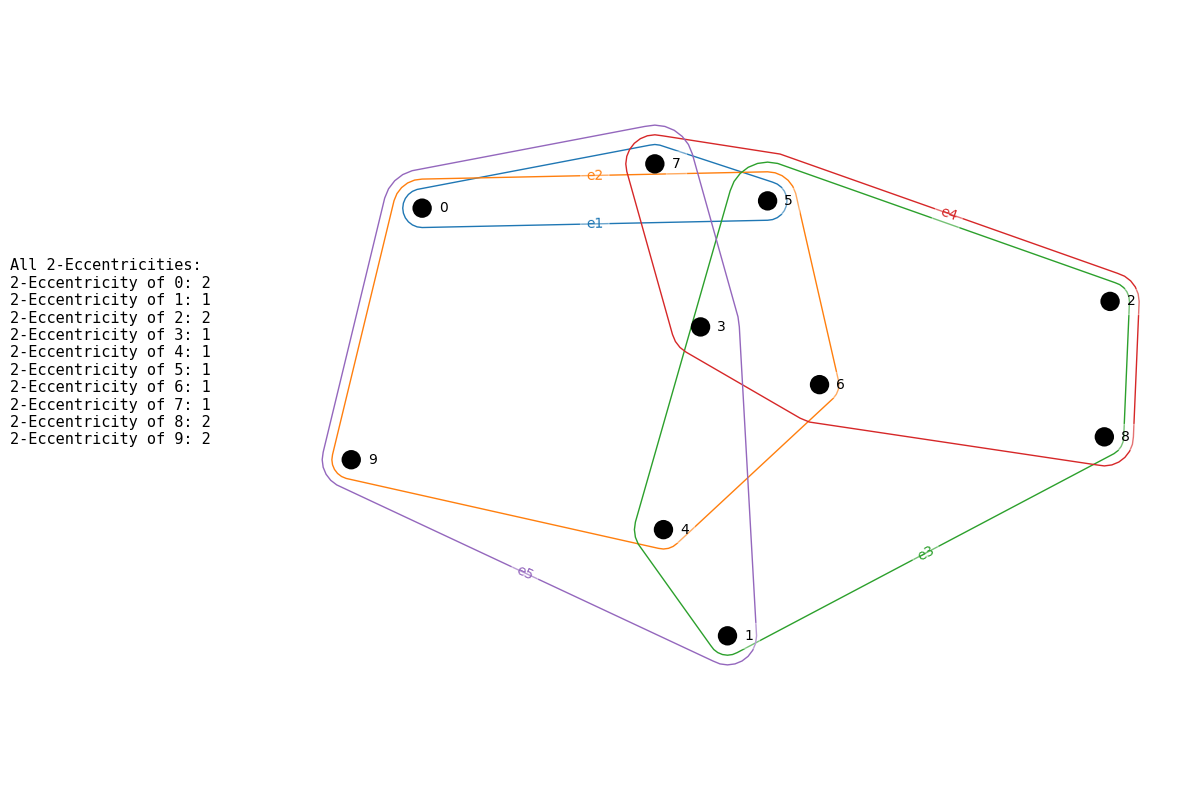

In [9]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(10)), hyperedge_names=[f"e{i+1}" for i in range(5)], m=5, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if H.is_connected(s=2): #is_connected(hg_d): 
        mat, rindex = H.adjacency_matrix(s=2,index=True)
        mat=mat.toarray()
        if np.count_nonzero(mat) > 6:
            break

print(hg_d)
H=hnx.Hypergraph(hg_d)
print("2-diameter =",H.diameter(s=2))

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []
text_output.append("\nAll 2-Eccentricities:")
eccentricity = eccentricities(hg_d)
for k,v in sorted(eccentricity.items()):
    if type(v) == int:
        text_output.append(f"2-Eccentricity of {k}: {v}")

text_display = "\n".join(text_output)
ax1.text(0, 0.7, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

{'e1': [0, 12, 16], 'e2': [1, 4], 'e3': [12, 15, 19], 'e4': [1, 3, 4, 7], 'e5': [3, 9, 13, 18], 'e6': [12, 15, 18], 'e7': [17], 'e8': [12, 13], 'e9': [0, 7, 16, 17], 'e10': [9, 19]}


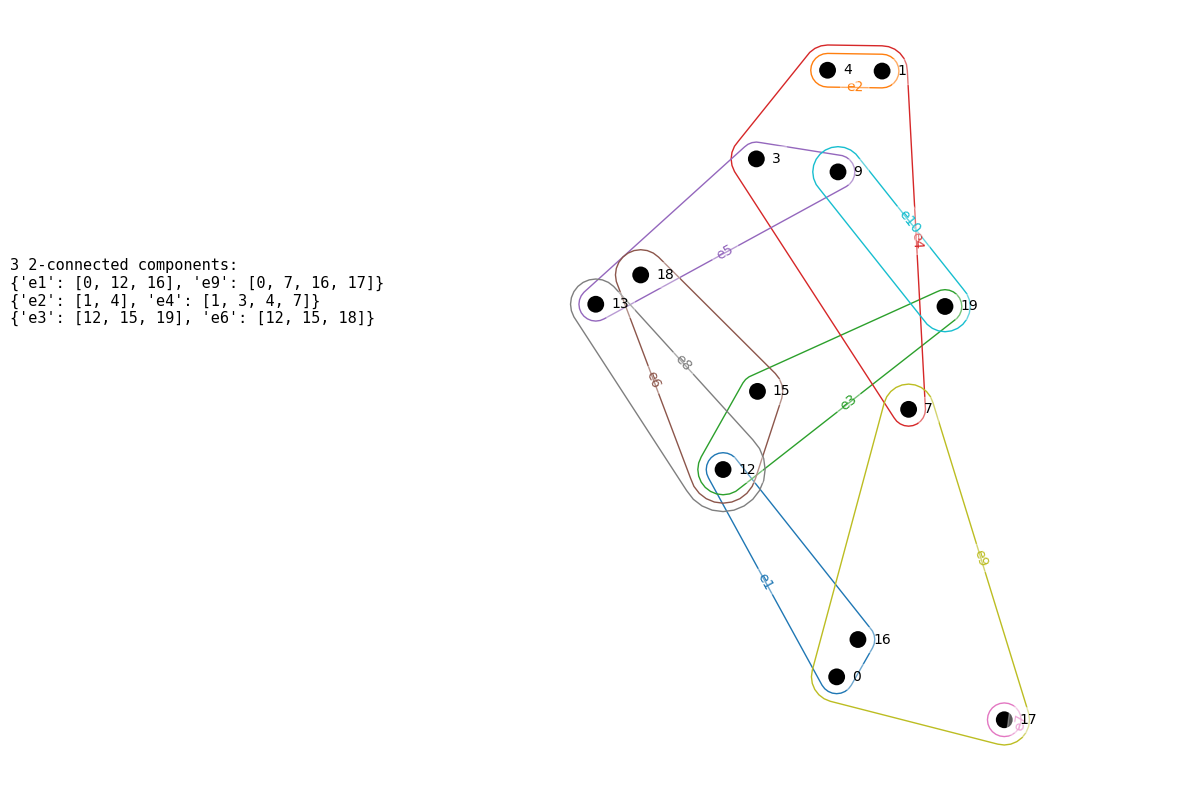

In [10]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(10)], m=10, minv=1, maxv=4, mw=0)
    H=hnx.Hypergraph(hg_d)
    if len(list(H.s_component_subgraphs(s=2))) > 2:
        if all(len(S)>1 for S in list(H.s_component_subgraphs(s=2))):
            break
print(hg_d)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []
text_output.append(f"\n{len(list(H.s_component_subgraphs(s=2)))} 2-connected components:")
H=hnx.Hypergraph(hg_d)
for comp in H.s_component_subgraphs(s=2):
    text_output.append(str(comp.incidence_dict))

text_display = "\n".join(text_output)
ax1.text(0, 0.7, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='4'></a>
## <span style="color:green">4. Simplicial Representation of Hypergraphs</span>

{'e1': [3, 11, 13, 14], 'e2': [2, 5, 8, 9, 13], 'e3': [8, 14], 'e4': [5, 6, 7, 9, 10, 12], 'e5': [4, 6, 8, 10, 11], 'e6': [5, 6, 12, 14]}


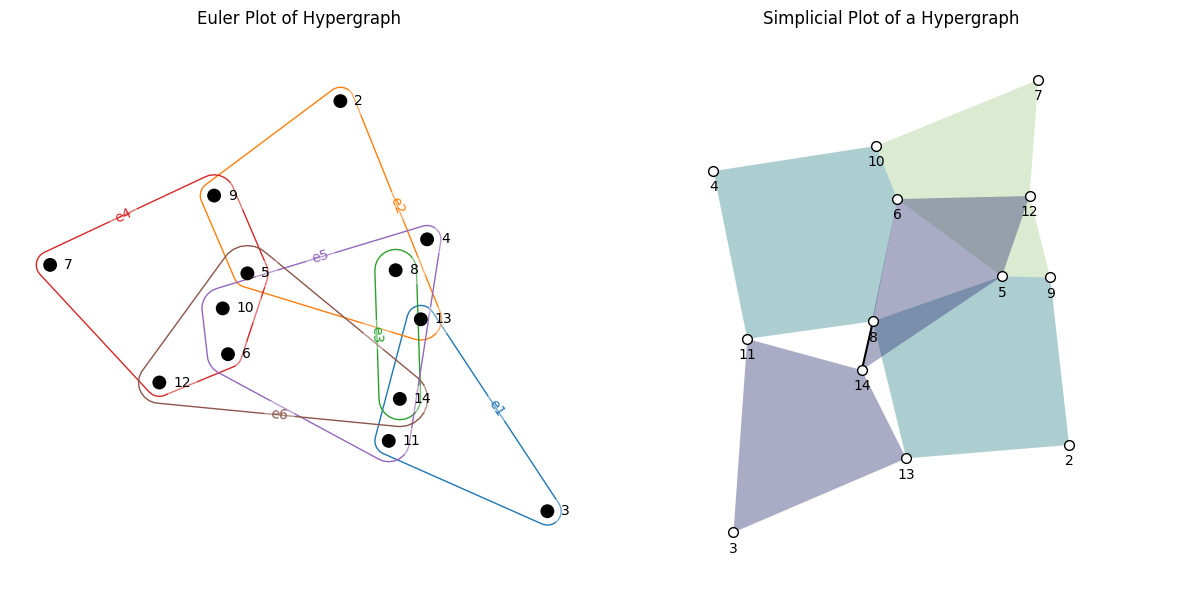

In [11]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(15)), hyperedge_names=[f"e{i+1}" for i in range(6)], m=6, minv=1, maxv=6, mw=0)
    if is_connected(hg_d):
        break
print(hg_d)
H_hnx = hnx.Hypergraph(hg_d)

H_xgi = xgi.Hypergraph()
H_xgi.add_edges_from(list(hg_d.values()))  
pos = xgi.barycenter_spring_layout(H_xgi)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

hnx.draw(H_hnx, ax=axes[0])
axes[0].set_title("Euler Plot of Hypergraph")

xgi.draw(H_xgi, pos=pos, ax=axes[1], node_labels=False)
for node, (x, y) in pos.items():
    axes[1].text(x, y - 0.04, str(node), ha="center", va="top", fontsize=10, color="black")
axes[1].set_title("Simplicial Plot of a Hypergraph")

plt.tight_layout()
plt.show()

<a id='5'></a>
## <span style="color:green">5. Bipartite Representation of Hypergraphs</span>

{'e1': [6, 7, 8, 14], 'e2': [8, 12], 'e3': [4, 14], 'e4': [5, 6], 'e5': [7, 13], 'e6': [1, 4, 5, 10, 11, 14]}


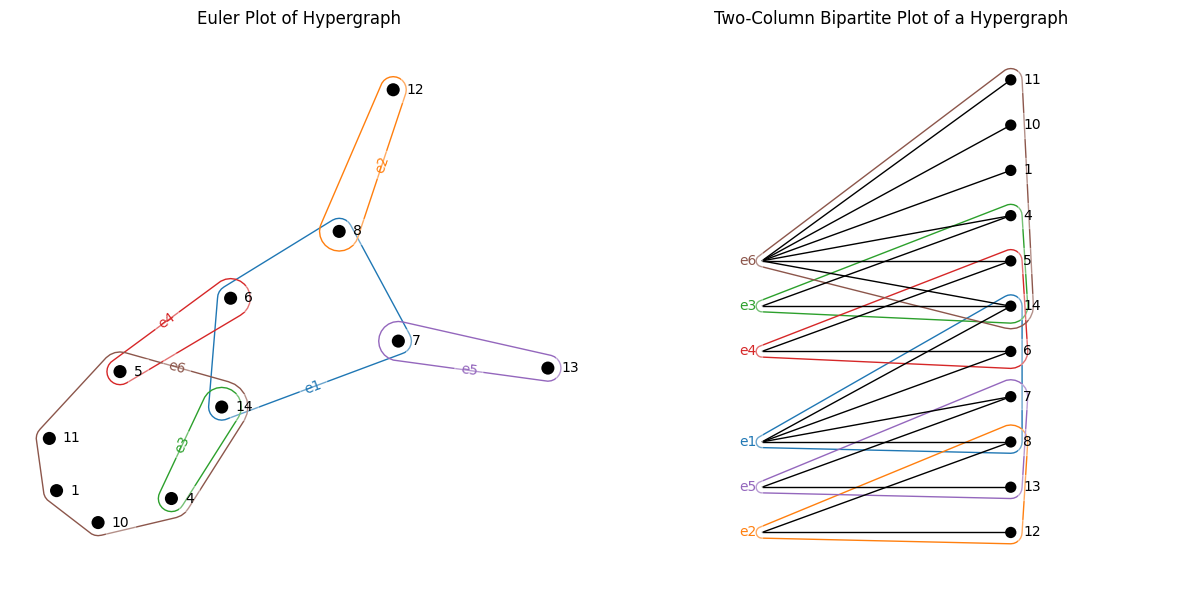

In [12]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(15)), hyperedge_names=[f"e{i+1}" for i in range(6)], m=6, minv=1, maxv=6, mw=0)
    if is_connected(hg_d):
        break
print(hg_d)
H_hnx = hnx.Hypergraph(hg_d)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

hnx.draw(H_hnx, ax=axes[0])
axes[0].set_title("Euler Plot of Hypergraph")

hnx.draw_bipartite_using_euler(H_hnx)
axes[1].set_title("Two-Column Bipartite Plot of a Hypergraph")

plt.tight_layout()
plt.show()

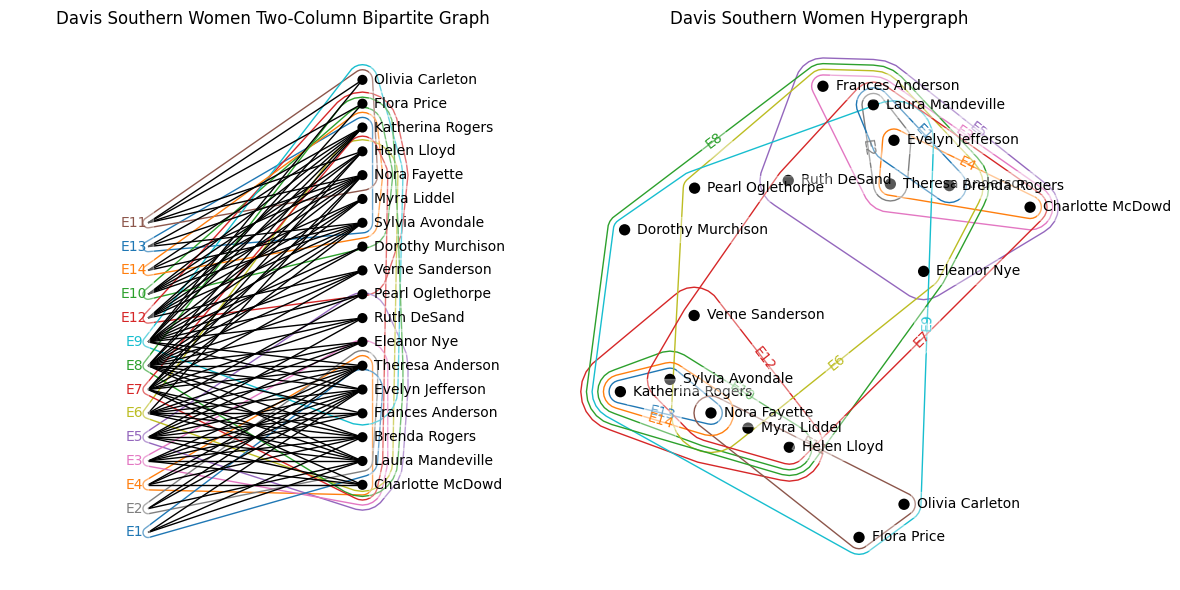

In [13]:
G=nx.davis_southern_women_graph()
bottom_nodes, top_nodes = bipartite.sets(G)
hg_d={e: list(G.neighbors(e)) for e in top_nodes}
H_hnx = hnx.Hypergraph(hg_d)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

hnx.draw_bipartite_using_euler(H_hnx, ax=axes[0])
axes[0].set_title("Davis Southern Women Two-Column Bipartite Graph")

hnx.draw(H_hnx, ax=axes[1])
axes[1].set_title("Davis Southern Women Hypergraph")

plt.tight_layout()
plt.show()